In [209]:
OPENSLIDE_PATH = 'C:\\openslide\\openslide-win64-20231011\\bin'

import os
if hasattr(os, 'add_dll_directory'):
    # Windows
    with os.add_dll_directory(OPENSLIDE_PATH):
        import openslide
else:
    import openslide

In [210]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tiatoolbox.tools import stainnorm
import random
from sklearn.model_selection import train_test_split
from script.models import attnet
from script.loss import *

In [211]:
img1 = cv2.imread(r'Ref\1.tif')
img2 = cv2.imread(r'Ref\2.tif')
img3 = cv2.imread(r'Ref\3.tif')
img4 = cv2.imread(r'Ref\4.tif')
img5 = cv2.imread(r'Ref\5.tif')
img6 = cv2.imread(r'Ref\6.png')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)
img5 = cv2.cvtColor(img5, cv2.COLOR_BGR2RGB)
img6 = cv2.cvtColor(img6, cv2.COLOR_BGR2RGB)


In [212]:
def image_mask_generator(image_paths, mask_paths,normalizer, batch_size,):
    num_training_samples = len(image_paths)
    while True:
        for i in range(0, num_training_samples, batch_size):
            batch_training_image_paths = image_paths[i:i + batch_size]
            batch_training_mask_paths = mask_paths[i:i + batch_size]

            batch_training_images = []
            batch_training_masks = []

            for image_path, mask_path in zip(batch_training_image_paths, batch_training_mask_paths):
                image = cv2.imread(image_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                if normalizer is not None:
                    image=normalizer.transform(image)
                image = image / 255.0  # Normalize to [0, 1]
                batch_training_images.append(image)

                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = mask / 255.0  # Normalize to [0, 1]
                batch_training_masks.append(mask)

            batch_training_images = np.array(batch_training_images)
            batch_training_masks = np.array(batch_training_masks)

            yield batch_training_images, batch_training_masks


In [213]:
image = os.listdir(r'datasets/cryonuseg/orignal/tissue images')
mask = os.listdir(r'datasets\cryonuseg\orignal\mask binary')
image = ['datasets\\cryonuseg\\orignal\\tissue images\\' + element for element in image]
mask = ['datasets\\cryonuseg\\orignal\\mask binary\\' + element for element in mask]

In [214]:
train_image, test_image, train_mask, test_mask = train_test_split(image, mask, test_size=0.2, random_state=42)
train_image, val_image, train_mask, val_mask = train_test_split(train_image, train_mask, test_size=0.2, random_state=42)

In [215]:
method = ["None","Macenko","Reinhard",  "Vahadane", "Ruifrok","random"]
reference = [img1,img2,img3,img4,img5,img6]

In [229]:
batch_size=1
md=1
rf=0
if method[md]=='None':
    nor=None
else:
    nor = stainnorm.get_normalizer(method[md])
    nor.fit(reference[rf])

model = attnet()

train_generator = image_mask_generator(train_image, train_mask,nor,batch_size)
validation_generator = image_mask_generator(val_image, val_mask,nor,batch_size)

steps_per_epoch = len(train_image) // batch_size
validation_steps = len(val_image) // batch_size

history = model.fit(
            train_generator,
            steps_per_epoch=steps_per_epoch,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=validation_steps,
            verbose=1
        )
model.save(f"Models\\new\\cryonuseg\\{md}_{rf}")

Epoch 1/100
19/19 [==============================] - 6s 282ms/step - loss: 0.5213 - dice_coefficient: 0.4787 - val_loss: 0.7360 - val_dice_coefficient: 0.2640
Epoch 2/100
19/19 [==============================] - 5s 264ms/step - loss: 0.4171 - dice_coefficient: 0.5829 - val_loss: 0.7380 - val_dice_coefficient: 0.2620
Epoch 3/100
19/19 [==============================] - 5s 265ms/step - loss: 0.3859 - dice_coefficient: 0.6141 - val_loss: 0.7626 - val_dice_coefficient: 0.2374
Epoch 4/100
19/19 [==============================] - 5s 259ms/step - loss: 0.3706 - dice_coefficient: 0.6294 - val_loss: 0.7567 - val_dice_coefficient: 0.2433
Epoch 5/100
19/19 [==============================] - 5s 256ms/step - loss: 0.3596 - dice_coefficient: 0.6404 - val_loss: 0.7273 - val_dice_coefficient: 0.2727
Epoch 6/100
19/19 [==============================] - 5s 256ms/step - loss: 0.3492 - dice_coefficient: 0.6508 - val_loss: 0.7206 - val_dice_coefficient: 0.2794
Epoch 7/100
19/19 [===========================

|2024-07-26|11:10:10.942| [WARNING] Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 24). These functions will not be directly callable after loading.


|2024-07-26|11:10:12.188| [INFO] Assets written to: Models\new\cryonuseg\1_0\assets


In [230]:
[history.history['dice_coefficient'][-1]]

[0.927894115447998]

In [231]:
[history.history['loss'][-1] ]

[0.07210586220026016]

In [232]:
[history.history['val_dice_coefficient'][-1] ]

[0.7415787577629089]

In [233]:
[history.history['val_loss'][-1] ]

[0.25842124223709106]

In [234]:
#test_image = os.listdir(r'datasets\Nuln\train\method_Reinhard\reference_img2')
#test_mask = os.listdir(r'datasets\Nuln\train\mask binary')
#test_image = [r'datasets\Nuln\train\method_Reinhard\reference_img2/' + element for element in test_image]
#test_mask = [r'datasets\Nuln\train\mask binary/' + element for element in test_mask]
#nor=None


In [235]:
'''batch_size=8
test_generator = image_mask_generator(test_image, test_mask,nor,batch_size)

dic = model.evaluate(test_generator, steps=(len(test_image) // batch_size))
print(dic)'''

'batch_size=8\ntest_generator = image_mask_generator(test_image, test_mask,nor,batch_size)\n\ndic = model.evaluate(test_generator, steps=(len(test_image) // batch_size))\nprint(dic)'

In [236]:
#test_image = os.listdir(r'datasets\Nuln\train\method_none\reference_none')
#test_mask = os.listdir(r'datasets\Nuln\train\mask binary')
#test_image = [r'datasets\Nuln\train\method_none\reference_none/' + element for element in test_image]
#test_mask = [r'datasets\Nuln\train\mask binary/' + element for element in test_mask]

#md=2
#rf=1
#nor = stainnorm.get_normalizer(method[md])
#nor.fit(reference[rf])

In [242]:
batch_size=1
test_generator = image_mask_generator(test_image, test_mask,nor,batch_size)

dic = model.evaluate(test_generator, steps=(len(test_image) // batch_size))
print(dic)

6/6 [==============================] - 1s 95ms/step - loss: 0.2059 - dice_coefficient: 0.7941
[0.2058854103088379, 0.7941145896911621]


In [243]:
batch_size=1
test_generator = image_mask_generator(test_image, test_mask,nor,batch_size)

predictions = model.predict(test_generator, steps=(len(test_image) // batch_size))
predictions=tf.cast((tf.squeeze(predictions) > 0.5), tf.int32)

6/6 [==============================] - 1s 116ms/step


In [244]:
d = []
a=[]
b=[]
for i in range(len(test_mask)):
        masks=(cv2.imread(test_mask[i], cv2.IMREAD_GRAYSCALE))
        masks=masks/255
        d.append(dice_coefficient(masks,predictions[i]).numpy())
        a.append(get_fast_aji(masks,predictions[i]))
        b.append(get_fast_pq(masks,predictions[i]))
dice=np.sum(d)/(len(test_mask))
aji=np.sum(a)/(len(test_mask))
bpq=np.sum(b)/(len(test_mask))

In [245]:
print(dice)
print(aji)
print(bpq)

0.7956272761027018
0.6663318137823051
0.587835882738291


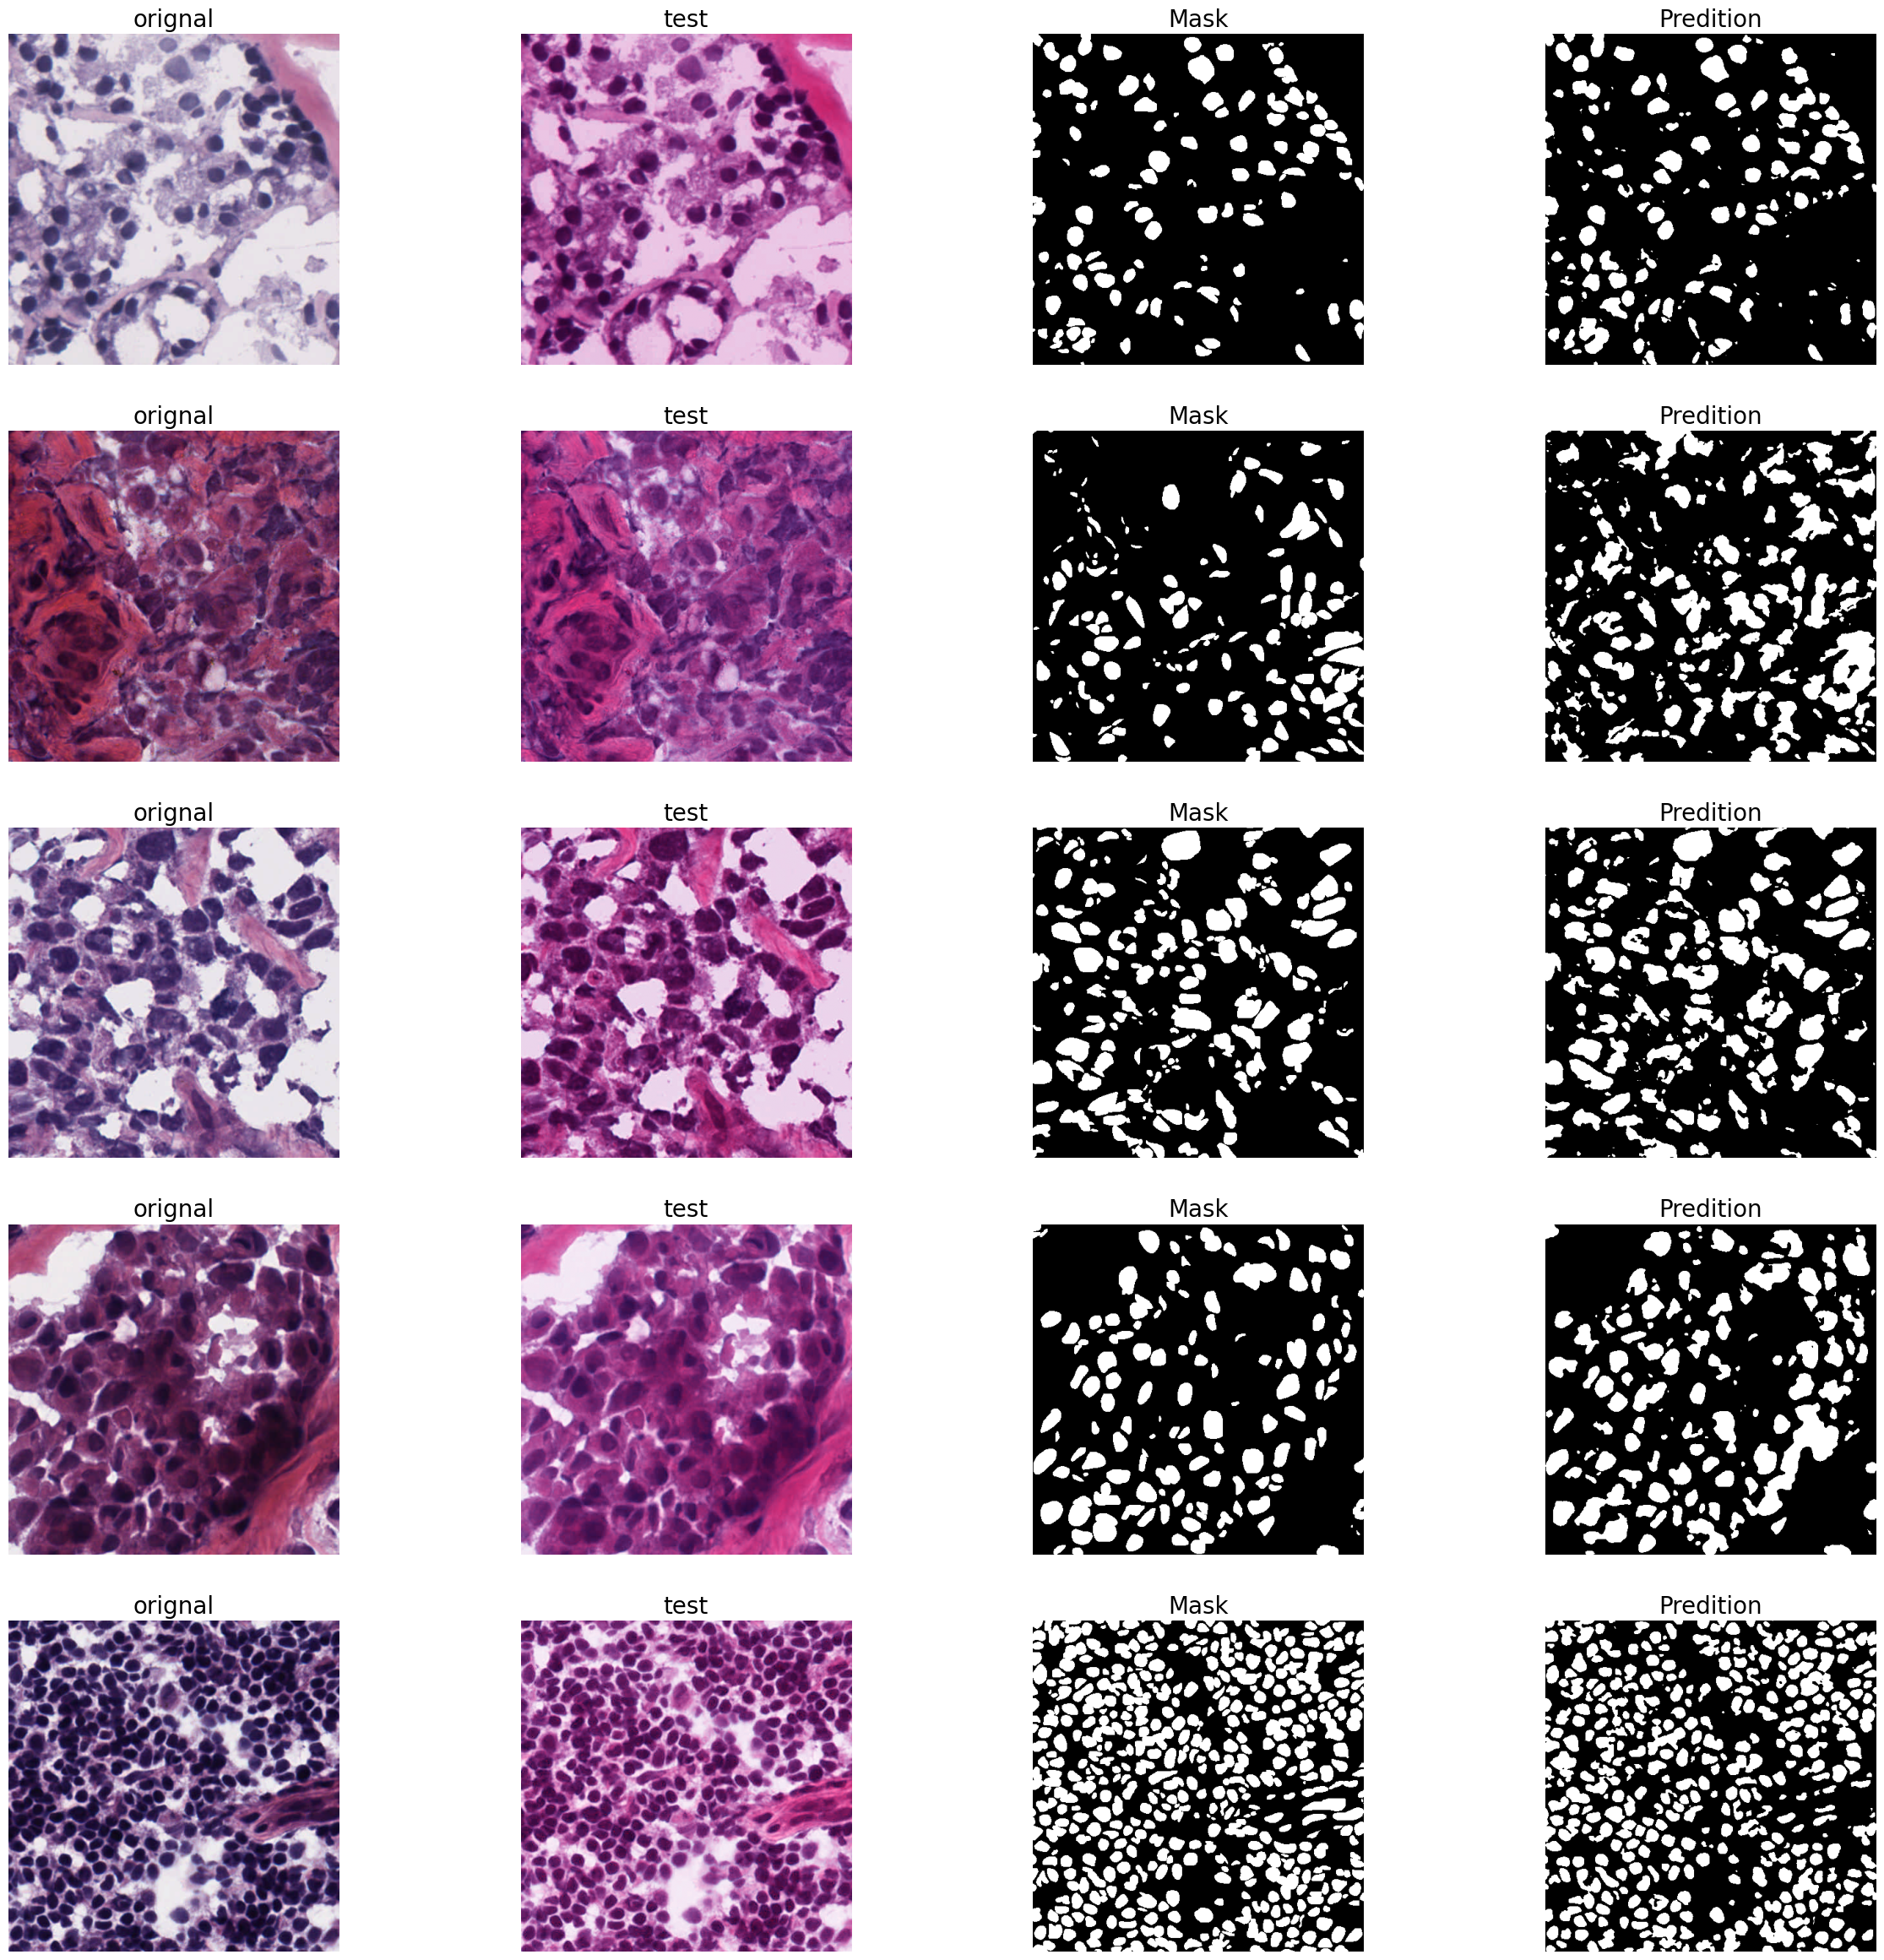

In [241]:
im=5
j=0
tm,mask=next(image_mask_generator(test_image, test_mask,nor,im))
plt.figure(figsize=(30,60))
for i in range(im):
    j+=1
    plt.subplot(10,4,j)
    plt.imshow(cv2.cvtColor(cv2.imread(test_image[i]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('orignal', fontsize = 20)
    
    j+=1
    plt.subplot(10,4,j)
    plt.imshow(tm[i])
    plt.axis('off')
    plt.title('test', fontsize = 20)

    j+=1
    plt.subplot(10,4,j)
    plt.imshow(mask[i],cmap='gray')
    plt.axis('off')
    plt.title('Mask', fontsize = 20)

    j+=1
    plt.subplot(10,4,j)
    plt.imshow(predictions[i],cmap='gray')
    plt.axis('off')
    plt.title(f'Predition', fontsize = 20)

plt.show()
    